# This notebook showcases the beamconv HWP class
We start by importing the relevant libraries and items

In [1]:
import os, pickle, time
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from beamconv import ScanStrategy, Beam, tools
import qpoint as qp
import seaborn as sns
from scipy.fftpack import fft, ifft
sns.set()
%matplotlib inline

First, we define a beam. Notice there are two attributes starting with hwp: the class proper, and the precomputed Mueller matrix parameters $T, \rho, c, s$. By default, the $\tt hwp\_precomp\_mueller$, and the HWP class' only attribute, $\tt stack$, are set to $\tt None$

In [2]:
beamy = Beam(name='beamy', sensitive_freq=280) 

In [3]:
print(beamy)
print(beamy.hwp)
print(beamy.hwp.stack)
print(beamy.hwp_precomp_mueller)

name    : beamy 
btype   : Gaussian 
alive   : True 
FWHM    : 43.2 arcmin 
az      : 0.0 deg 
el      : 0.0 deg 
polang  : 0.0 deg
po_file : None 

None
None


We assign a stack to hwp from one of our predefined models (there are five, see the source code for their names and characteristics). Stacks are made of slices of specific thickness, with a name, a type (isotropic or uniaxial), and index/indices (if the material is uniaxial) and losses (the imaginary part of the index). The slices are supposed to extend to infinity in the xy plane, and be stacked in the z axis.

In [4]:
beamy.hwp.choose_HWP_model(model_name='SPIDER_95')
print(beamy.hwp.stack)



______________________________________________________


Layer 1: Thickness 0.000427


Material: Quartz
Material Type: isotropic
Refractive Index: 1.951000
Loss tangent: 0.001200


______________________________________________________

Layer 2: Thickness 0.004930


Material: Sapphire at 4K
Material Type: uniaxial
Refractive Index (ordinary): 3.019000
Refractive Index (extraordinary): 3.336000
Loss Tangent (ordinary): 0.000230
Loss Tangent (extraordinary): 0.000125


	 Angle of extraordinary axis to x-axis: 0.000000
______________________________________________________

Layer 3: Thickness 0.000427


Material: Quartz
Material Type: isotropic
Refractive Index: 1.951000
Loss tangent: 0.001200


______________________________________________________



We can then call the hwp method $\tt \_compute4params$ for a particular frequency and angle of incidence to calculate the $\tt hwp\_precomp\_mueller$ for that particular beam.

In [5]:
beamy.hwp_precomp_mueller = beamy.hwp.compute4params(freq=100, alpha= 0.01)
print(beamy.hwp_precomp_mueller)

[ 0.94377628 -0.00656764 -0.99086059 -0.13472995]


We can also create our own material stack, by supplying $\tt \_stack\_builder$ with its own layers. Layers will be named by a number. 'angles' corresponds to the rotation of the slice around the z-axis (with angles=0 for the extraordinary axis along x), we usually set it to be zero. Note that we now compute the Muelller parameters using the elevation and the sensitive frequency of the beam !

In [6]:
thicknesses=np.array([4.3, 1.5])
indices = np.array([[1.,1.],[1.5,1.8]])
losses = np.array([[0.,0.],[1e-4,1e-4]])
angles = np.array([0.,0.])
beamy.hwp.stack_builder(thicknesses=thicknesses, indices=indices, losses=losses, angles=angles)
print(beamy.hwp.stack)
beamy.hwp_precomp_mueller = beamy.hwp.compute4params(freq=beamy.sensitive_freq, alpha= np.radians(beamy.el))
print(beamy.hwp_precomp_mueller)



______________________________________________________


Layer 1: Thickness 0.004300


Material: 0
Material Type: isotropic
Refractive Index: 1.000000
Loss tangent: 0.000000


______________________________________________________

Layer 2: Thickness 0.001500


Material: 1
Material Type: uniaxial
Refractive Index (ordinary): 1.500000
Refractive Index (extraordinary): 1.800000
Loss Tangent (ordinary): 0.000100
Loss Tangent (extraordinary): 0.000100


	 Angle of extraordinary axis to x-axis: 0.000000
______________________________________________________

[ 0.96596062  0.02599666 -0.86963699  0.49300677]


$\tt Beam$ also has a function that defines the stack and computes the parameters in one go. I would recommend using it instead of the other two. It will prioritize the model_name argument.

In [7]:
beamy.set_HWP_values(model_name='1layer_HWP', thicknesses=None, indices=None, losses=None, angles=None)
print(beamy.hwp.stack)
print(beamy.hwp_precomp_mueller)



______________________________________________________


Layer 1: Thickness 0.000305


Material: RT Duroid
Material Type: isotropic
Refractive Index: 1.715000
Loss tangent: 0.001200


______________________________________________________

Layer 2: Thickness 0.003150


Material: Sapphire
Material Type: uniaxial
Refractive Index (ordinary): 3.070000
Refractive Index (extraordinary): 3.410000
Loss Tangent (ordinary): 0.000230
Loss Tangent (extraordinary): 0.000125


	 Angle of extraordinary axis to x-axis: 0.000000
______________________________________________________

Layer 3: Thickness 0.000305


Material: RT Duroid
Material Type: isotropic
Refractive Index: 1.715000
Loss tangent: 0.001200


______________________________________________________

[ 0.9326036  -0.00421984  0.99947879  0.03200518]


We generate some set of HWP angles $\theta$ and boresight angles $\psi$. We then call the $\tt \_get\_Mueller\_top\_row $ method of the beam to get the values of the top-row elements of the complete Mueller matrix. $\xi$ is the detector's angle.

In [8]:
theta = np.pi*np.arange(0,2, 0.01)
psi = np.zeros(theta.size)
M_II, M_IP, M_IP_bar = beamy.get_Mueller_top_row(xi=0.0, psi=psi, theta=theta)

This works even if the $\tt precomp\_mueller$ has not be calculated, as the method will evaluate it from the $\tt hwp.stack$ if there is none yet. It will only do so once for the beam's lifetime, which increases performance.

In [9]:
beamy.hwp_precomp_mueller=None
beamy.hwp.choose_HWP_model(model_name='HWP_only')
M_II, M_IP, M_IP_bar = beamy.get_Mueller_top_row(xi=0.0, psi=psi, theta=theta)

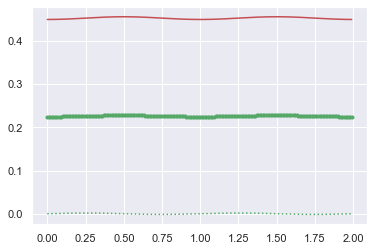

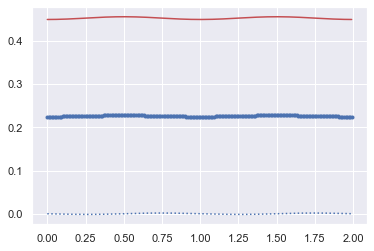

In [10]:
plt.figure(1)
mip_plot = plt.plot(theta/np.pi, M_II, 'r', theta/np.pi, np.real(M_IP), 'g.', 
                    theta/np.pi, np.imag(M_IP), 'g:')
plt.figure(2)
mipbar_plot = plt.plot(theta/np.pi, M_II, 'r', theta/np.pi, np.real(M_IP_bar), 'b.', 
                     theta/np.pi, np.imag(M_IP_bar), 'b:')

We want to estimate the gain of varous HWPs, as a function of beam frequency and angle of incidence

In [11]:
elevations = np.arange(0,20,.2)
frequencies = np.arange(70, 170, 1.)
Mis = np.zeros((elevations.size, frequencies.size,5))
Mip = np.zeros((elevations.size,frequencies.size,5), dtype=np.complex128)
Mipbar = np.zeros((elevations.size,frequencies.size,5), dtype=np.complex128)
theta = 0
psi = 0
for i, el in enumerate(elevations):
    beamy.el = el
    for j, freq in enumerate(frequencies):
        beamy.sensitive_freq = freq
        beamy.set_HWP_values(model_name='HWP_only')
        Mis[i,j,0], Mip[i,j,0], Mipbar[i,j,0] = beamy.get_Mueller_top_row(xi=0.0, psi=psi, theta=theta)
        beamy.set_HWP_values(model_name='1layer_HWP')
        Mis[i,j,1], Mip[i,j,1], Mipbar[i,j,1] = beamy.get_Mueller_top_row(xi=0.0, psi=psi, theta=theta)
        beamy.set_HWP_values(model_name='2layer_HWP')
        Mis[i,j,2], Mip[i,j,2], Mipbar[i,j,2] = beamy.get_Mueller_top_row(xi=0.0, psi=psi, theta=theta)
        beamy.set_HWP_values(model_name='SPIDER_95')
        Mis[i,j,3], Mip[i,j,3], Mipbar[i,j,3] = beamy.get_Mueller_top_row(xi=0.0, psi=psi, theta=theta)
        beamy.set_HWP_values(model_name='SPIDER_150')
        Mis[i,j,4], Mip[i,j,4], Mipbar[i,j,4] = beamy.get_Mueller_top_row(xi=0.0, psi=psi, theta=theta)


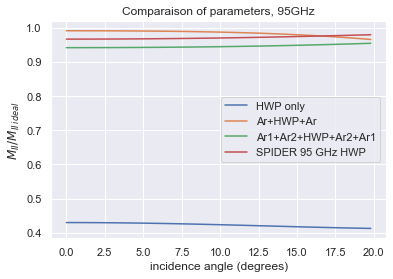

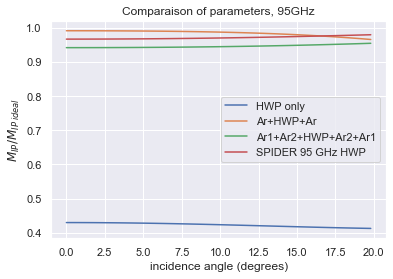

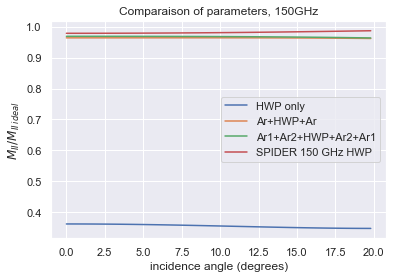

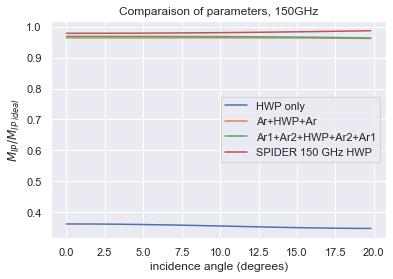

In [12]:
a =plt.figure(1)
plt.title('Comparaison of parameters, 95GHz')
plt.plot(elevations, Mis[:,24,0]/.5, label='HWP only')
plt.plot(elevations, Mis[:,24,1]/.5, label = 'Ar+HWP+Ar')
plt.plot(elevations, Mis[:,24,2]/.5, label = 'Ar1+Ar2+HWP+Ar2+Ar1')
plt.plot(elevations, Mis[:,24,3]/.5, label='SPIDER 95 GHz HWP')
plt.xlabel('incidence angle (degrees)')
plt.ylabel(r'$M_{II}/M_{II \: ideal}$')
plt.legend()
b =plt.figure(2)
plt.title('Comparaison of parameters, 95GHz')
plt.plot(elevations, np.real(Mip)[:,24,0]/.25, label='HWP only')
plt.plot(elevations, np.real(Mip)[:,24,1]/.25, label = 'Ar+HWP+Ar') 
plt.plot(elevations, np.real(Mip)[:,24,2]/.25, label = 'Ar1+Ar2+HWP+Ar2+Ar1')
plt.plot(elevations, np.real(Mip)[:,24,3]/.25, label='SPIDER 95 GHz HWP')
plt.xlabel('incidence angle (degrees)')
plt.ylabel(r'$M_{IP}/M_{IP \: ideal}$')
plt.legend()
a =plt.figure(3)
plt.title('Comparaison of parameters, 150GHz')
plt.plot(elevations, Mis[:,79,0]/.5, label='HWP only')
plt.plot(elevations, Mis[:,79,1]/.5, label = 'Ar+HWP+Ar')
plt.plot(elevations, Mis[:,79,2]/.5, label = 'Ar1+Ar2+HWP+Ar2+Ar1')
plt.plot(elevations, Mis[:,79,4]/.5, label='SPIDER 150 GHz HWP')
plt.xlabel('incidence angle (degrees)')
plt.ylabel(r'$M_{II}/M_{II \: ideal}$')
plt.legend()
b =plt.figure(4)
plt.title('Comparaison of parameters, 150GHz')
plt.plot(elevations, np.real(Mip)[:,79,0]/.25, label='HWP only')
plt.plot(elevations, np.real(Mip)[:,79,1]/.25, label = 'Ar+HWP+Ar') 
plt.plot(elevations, np.real(Mip)[:,79,2]/.25, label = 'Ar1+Ar2+HWP+Ar2+Ar1')
plt.plot(elevations, np.real(Mip)[:,79,4]/.25, label='SPIDER 150 GHz HWP')
plt.xlabel('incidence angle (degrees)')
plt.ylabel(r'$M_{IP}/M_{IP \: ideal}$')
plt.legend()

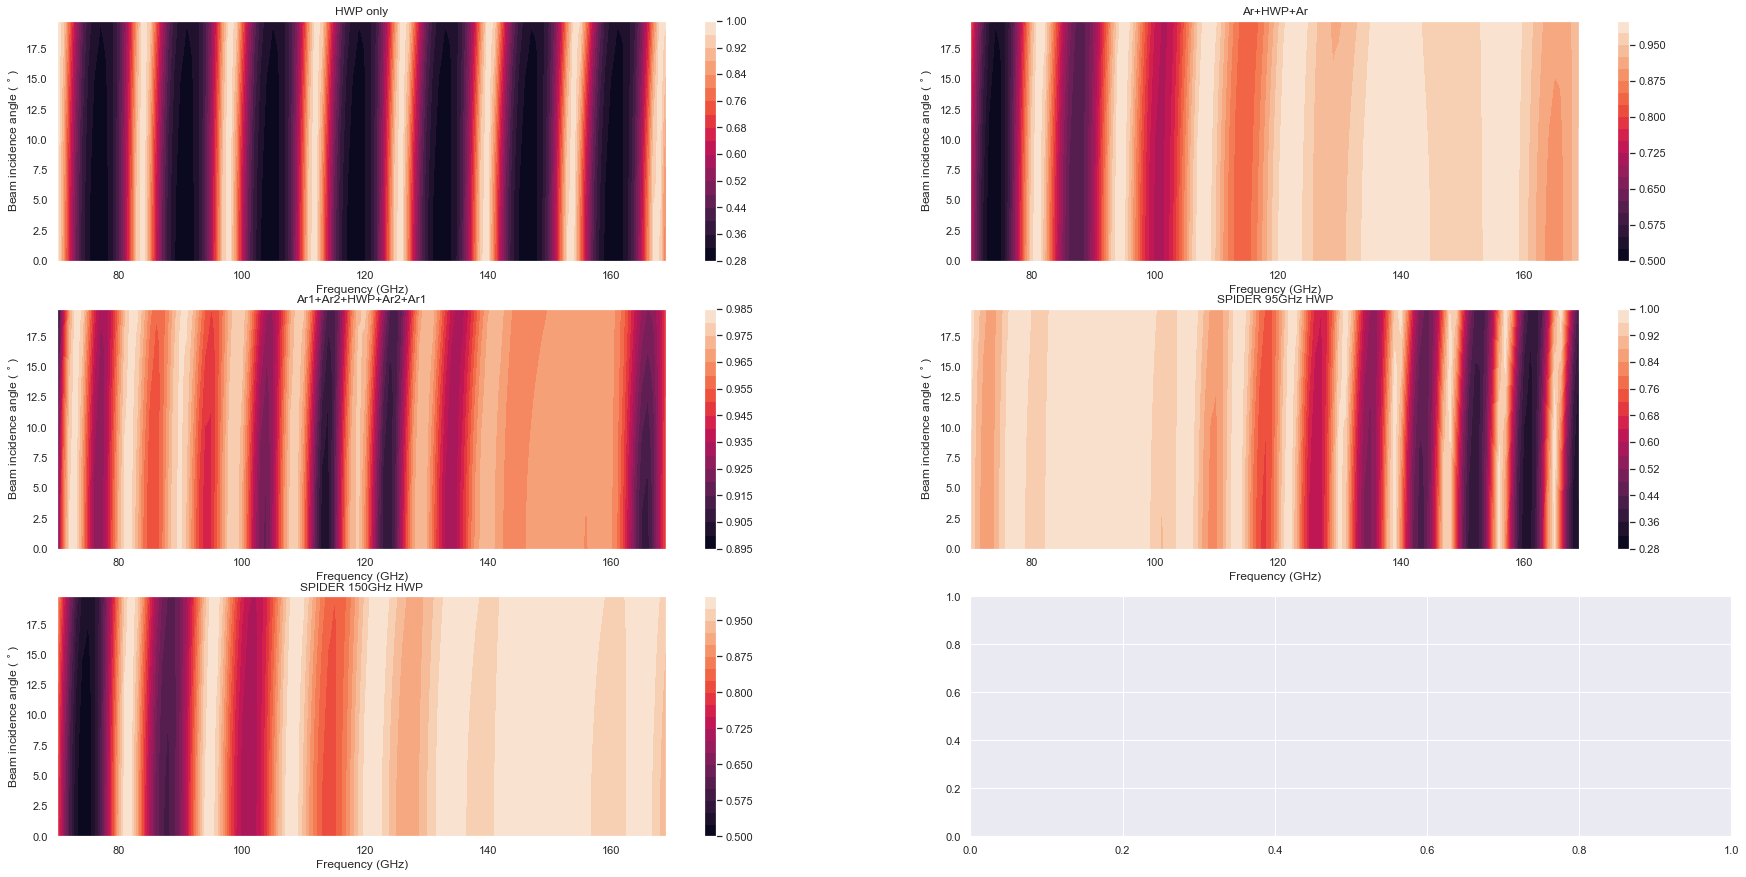

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(30,15))
axes[0,0].set_xlabel('Frequency (GHz)')
axes[0,0].set_ylabel(r'Beam incidence angle ($\:^\circ$)')
axes[0,0].set_title('HWP only')
axes[0,1].set_xlabel('Frequency (GHz)')
axes[0,1].set_ylabel(r'Beam incidence angle ($\:^\circ$)')
axes[0,1].set_title('Ar+HWP+Ar')
axes[1,0].set_xlabel('Frequency (GHz)')
axes[1,0].set_ylabel(r'Beam incidence angle ($\:^\circ$)')
axes[1,0].set_title('Ar1+Ar2+HWP+Ar2+Ar1')
axes[1,1].set_xlabel('Frequency (GHz)')
axes[1,1].set_ylabel(r'Beam incidence angle ($\:^\circ$)')
axes[1,1].set_title('SPIDER 95GHz HWP')
axes[2,0].set_xlabel('Frequency (GHz)')
axes[2,0].set_ylabel(r'Beam incidence angle ($\:^\circ$)')
axes[2,0].set_title('SPIDER 150GHz HWP')
ul = axes[0,0].contourf(frequencies,elevations,Mis[:,:,0]/.5,20)
plt.colorbar(ul, ax=axes[0,0])
ur = axes[0,1].contourf(frequencies,elevations,Mis[:,:,1]/.5,20)
plt.colorbar(ur, ax=axes[0,1])
ll = axes[1,0].contourf(frequencies,elevations,Mis[:,:,2]/.5,20)
plt.colorbar(ll, ax=axes[1,0])
lr = axes[1,1].contourf(frequencies,elevations,Mis[:,:,3]/.5,20)
plt.colorbar(lr, ax=axes[1,1])
ul = axes[2,0].contourf(frequencies,elevations,Mis[:,:,4]/.5,20)
plt.colorbar(ul, ax=axes[2,0])

## Scanning with the imperfect HWP
We now examin how scanning the sky would work with the new HWP methods we defined. Let's start with a scan of a uniform sky patch. 

We start by defining a random sky, so the alms are all different. We then select a disk on the sky and set it to be zero in I and U, and constant in Q. We compute the alms.

In [33]:
lmax=700
sky_maps = np.random.uniform(low=-1, high=1, size=(3,hp.nside2npix(512)))
ra0  = -10
dec0 = -57.5
vec_center = hp.ang2vec(theta=ra0, phi=dec0, lonlat=True)
disk_size = 10.0*np.pi/180.0
disk = hp.query_disc(nside=512,vec=vec_center, radius=disk_size)
sky_maps[0,disk] = 0 #I
sky_maps[1,disk] = 1 #Q
sky_maps[2,disk] = 0 #U
alm = hp.sphtfunc.map2alm(sky_maps, lmax=lmax, mmax=None, iter=3, pol=True)

We now define a focal plane with one detector, and a scan strategy within the disk.

In [34]:
fwhm = 40
fhwp_rot = 0.025
fsamp = 12.01
beam_opts = dict(lmax=lmax,
                 fwhm=fwhm,       # Gaussian co-pol beam, so only specify FWHM (arcmin)
                 btype='Gaussian')

spin_opts = dict(max_spin=2,      # Symmetric beams, so 2 is sufficient
                 nside_spin=256)  # nside of scanned maps 

scan_opts = dict(ra0=ra0,       # Center of scan
                 dec0=dec0,
                 az_throw=3,     # Scan width
                 scan_speed=1,
                 verbose=0)

mlen        = 200        # Mission length in seconds
rot_period  = 6 * 60 * 60
step_period = 1.5 * 60 * 60

bideal = ScanStrategy(duration=mlen,
                  sample_rate=fsamp, # sample rate in Hz
                  location='spole')  # Instrument at south pole (preset)
# Create a Gaussian beam (f.o.v. is 3 degrees)
bideal.create_focal_plane(nrow=1, ncol=1, fov=3, no_pairs=True,**beam_opts)
# Calculate tods in two chunks
chunks = bideal.partition_mission(0.5*bideal.mlen*bideal.fsamp) 
# Allocate and assign parameters for mapmaking
bideal.allocate_maps(nside=256)
# Set instrument rotation
bideal.set_instr_rot(period=rot_period, angles=[0,30, 60, 90, 60, 30, 0])
# Set elevation stepping
bideal.set_el_steps(step_period, steps=[-4,-3,-2,-1,0,1,2,3,4])
# Set HWP modulation
bideal.set_hwp_mod(mode='continuous', freq=fhwp_rot)#mode='continuous'

We scan with the ideal half wave plate, by setting the hwp_status variable of scan_instrument_mpi to 'ideal'. Model and frequency do not matter here.

In [35]:
bideal.scan_instrument_mpi(alm, hwp_status='ideal', **scan_opts)

We do the same scan for the non-ideal HWPs, this time setting hwp_status to 'non-ideal' (the default value). We store the time ordered data.

In [39]:
hwp_models = ('HWP_only', '1layer_HWP', '2layer_HWP', 'SPIDER_95', 'SPIDER_150', '1AR3BR')
freq=95.
tod_res = np.zeros((6, bideal.tod.size))

for i, hwp_model in enumerate(hwp_models):
    hwp = Beam().hwp()
    hwp.choose_HWP_model(hwp_model)
    bnideal = ScanStrategy(duration=mlen,
                  sample_rate=fsamp, # sample rate in Hz
                  location='spole')  # Instrument at south pole (preset)
    beam_opts = dict(lmax=lmax,
             fwhm=fwhm,       # Gaussian co-pol beam, so only specify FWHM (arcmin)
             btype='Gaussian', sensitive_freq=freq, hwp=hwp)
    # Calculate tods in two chunks
    bnchunks = bnideal.partition_mission(0.5*bnideal.mlen*bnideal.fsamp) 
    # Allocate and assign parameters for mapmaking
    bnideal.allocate_maps(nside=256)
    # Set instrument rotation
    bnideal.set_instr_rot(period=rot_period, angles=[0,30, 60, 90, 60, 30, 0])
    # Set elevation stepping
    bnideal.set_el_steps(step_period, steps=[-4,-3,-2,-1,0,1,2,3,4])
    # Set HWP modulation
    bnideal.set_hwp_mod(mode='continuous', freq=fhwp_rot)#mode='continuous'
    bnideal.create_focal_plane(nrow=1, ncol=1, fov=3, no_pairs=True,**beam_opts)

    # Scan
    bnideal.scan_instrument_mpi(alm, hwp_status='non-ideal', muell_mat_model='simple', **scan_opts)
    tod_res[i,:] = bnideal.tod

We plot the scanned TOD, how it differs from the ideal case, and a very quick Fourier transform.

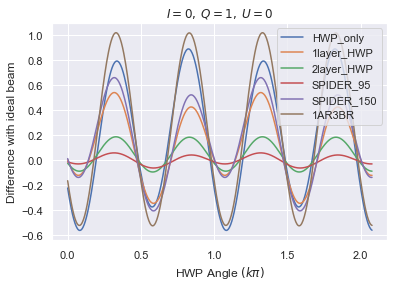

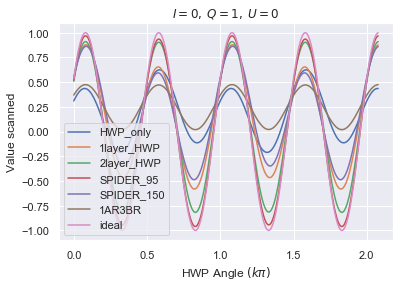

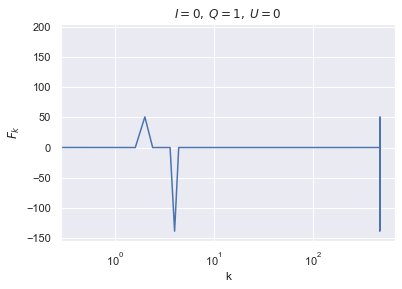

In [40]:
plt.figure(1)
plt.title(r'$I=0,\:Q=1, \:U=0$')
plt.plot(np.arange(500)*fhwp_rot/fsamp *2 ,tod_res[0,:500]-bideal.tod[:500])
plt.plot(np.arange(500)*fhwp_rot/fsamp *2 ,tod_res[1,:500]-bideal.tod[:500])
plt.plot(np.arange(500)*fhwp_rot/fsamp *2 ,tod_res[2,:500]-bideal.tod[:500])
plt.plot(np.arange(500)*fhwp_rot/fsamp *2 ,tod_res[3,:500]-bideal.tod[:500])
plt.plot(np.arange(500)*fhwp_rot/fsamp *2 ,tod_res[4,:500]-bideal.tod[:500])
plt.plot(np.arange(500)*fhwp_rot/fsamp *2 ,tod_res[5,:500]-bideal.tod[:500])
plt.xlabel(r'HWP Angle $( k\pi)$')
plt.ylabel('Difference with ideal beam')
#plt.ylabel('Difference with ideal hwp for Spider 150 hwp')
plt.legend(hwp_models)

plt.figure(2)
plt.title(r'$I=0,\:Q=1,\:U=0$')
plt.plot(np.arange(500)*fhwp_rot/fsamp *2 ,tod_res[0,:500])
plt.plot(np.arange(500)*fhwp_rot/fsamp *2 ,tod_res[1,:500])
plt.plot(np.arange(500)*fhwp_rot/fsamp *2 ,tod_res[2,:500])
plt.plot(np.arange(500)*fhwp_rot/fsamp *2 ,tod_res[3,:500])
plt.plot(np.arange(500)*fhwp_rot/fsamp *2 , tod_res[4,:500])
plt.plot(np.arange(500)*fhwp_rot/fsamp *2 , tod_res[5,:500])
plt.plot(np.arange(500)*fhwp_rot/fsamp *2 , bideal.tod[:500])

plt.xlabel(r'HWP Angle $(k\pi)$')
plt.ylabel('Value scanned')
plt.legend(hwp_models+('ideal',))
#plt.legend(('SPIDER_150','ideal'))

plt.figure(3)
plt.title(r'$I=0,\:Q=1,\:U=0$')
xf = np.linspace(0.0, 1.0/(fhwp_rot/fsamp), bideal.tod.size)
plt.xlabel('k')
plt.ylabel(r'$F_k$')
plt.semilogx(xf, fft(tod_res[4,:]-bideal.tod))

We can also look at what the final product of a proper scan looks like, i.e. a map: 

Before starting the scanning simulation, we need to invoke some model of the underlying sky. For this example, we describe the sky as statistically isotropic and Gaussian I, Q, and U fields (with underlying power spectra and correlations as determined in the WMAP 7-year release).

## Effect on maps

In [19]:
#cls = np.zeros((5,2700))
#cls[0,:] = np.arange(2700, dtype=np.int16)
cls = np.loadtxt('../ancillary/wmap7_r0p03_lensed_uK_ext.txt',
                 unpack=True) # Cl in uK^2
lmax=700 
ell, cls = cls[0], cls[1:]
np.random.seed(25) 
alm = hp.synalm(cls, lmax=lmax, new=True, verbose=True) # uK

Here we set parameters that describe the pointing, the instrument and the beams. For this example, we just pick identical symmetric Gaussian beams with no cross-polarization. This will later allow us to easily check whether the code reproduces this known case.

In [28]:
fwhm = 40
spider_hwp = Beam().hwp()
spider_hwp.choose_HWP_model('1AR3BR')
beam_opts = dict(lmax=lmax,
                 fwhm=fwhm,       # Gaussian co-pol beam, so only specify FWHM (arcmin)
                 btype='Gaussian',hwp=spider_hwp, sensitive_freq=95.)

spin_opts = dict(max_spin=2,      # Symmetric beams, so 2 is sufficient
                 nside_spin=256)  # nside of scanned maps 

scan_opts = dict(ra0=[-10],       # Center of scan
                 dec0=[-57.5],
                 az_throw=20,     # Scan width
                 scan_speed=1,
                 verbose=0)

mlen        = 14 * 24 * 60 * 60        # Mission length in seconds
rot_period  = 6 * 60 * 60
step_period = 1.5 * 60 * 60

An seasoned experimentalist might notice that we are defining scan regions and parameters that are not very dissimilar from that of the BICEP class of experiments. These experiments scan around 1-2% of the sky. Now that we have defined some of the boundary conditions of our experiment, we can start initializing scan strategy objects.

In [29]:
bideal = ScanStrategy(duration=mlen,
                  sample_rate=12.01, # sample rate in Hz
                  location='spole')  # Instrument at south pole (preset)
bnideal = ScanStrategy(duration=mlen,
                  sample_rate=12.01, # sample rate in Hz
                  location='spole')  # Instrument at south pole (preset)

# Create a 3 x 3 square grid of Gaussian beams (f.o.v. is 3 degrees)
bideal.create_focal_plane(nrow=2, ncol=2, fov=3, no_pairs=True,**beam_opts)
bnideal.create_focal_plane(nrow=2, ncol=2, fov=3, no_pairs=True,**beam_opts)

# Calculate tods in two chunks
chunks = bideal.partition_mission(0.5*bideal.mlen*bideal.fsamp) 
nideal_chunks = bnideal.partition_mission(0.5*bnideal.mlen*bnideal.fsamp) 
# Allocate and assign parameters for mapmaking
bideal.allocate_maps(nside=256)
bnideal.allocate_maps(nside=256)
# Set instrument rotation
bideal.set_instr_rot(period=rot_period, angles=[0,30, 60, 90, 60, 30, 0])
bnideal.set_instr_rot(period=rot_period, angles=[0,30, 60, 90, 60, 30, 0])
# Set elevation stepping
bideal.set_el_steps(step_period, steps=[-4,-3,-2,-1,0,1,2,3,4])
bnideal.set_el_steps(step_period, steps=[-4,-3,-2,-1,0,1,2,3,4])
# Set HWP modulation
bideal.set_hwp_mod(mode='continuous', freq=1.)#mode='continuous'
bnideal.set_hwp_mod(mode='continuous', freq=1.)#mode='continuous'

Here we actually scan the sky. We also solve for the I, Q and U maps and calculate the condition number of the per-pixel projection matrix. This might take a minute on a single core. Notice that the half-wave plate's argument accepts two values, 'ideal' and 'non-ideal'. Other values will raise a ValueError() Default is ideal.

In [30]:
# Generate timestreams, bin them and store as attributes
start_time = time.time()

bideal.scan_instrument_mpi(alm, hwp_status='ideal', **scan_opts)

print(time.time()-start_time)

# Solve for the maps
ideal_maps, ideal_cond = bideal.solve_for_map()

start_time = time.time()

bnideal.scan_instrument_mpi(alm, hwp_status='non-ideal', **scan_opts)
print(time.time()-start_time)

maps, cond = bnideal.solve_for_map()

start_time = time.time()

bnideal.scan_instrument_mpi(alm, hwp_status='non-ideal', muell_mat_model='full', **scan_opts)
print(time.time()-start_time)

full_maps, full_cond = bnideal.solve_for_map()


/Users/personal/Library/Python/3.7/lib/python/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


92.05820608139038


/Users/personal/Library/Python/3.7/lib/python/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


88.95676374435425


/Users/personal/Library/Python/3.7/lib/python/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


113.40587186813354


# Results

With the data generated and binned into maps, we can visualize the results. We plot the condition number map and the solved I, Q and U maps. We expect the condition number to be as low as possible (=2) for almost all pixels because of the continuous HWP rotation and the instrument rotation. We can see the differences between the non-ideal HWP model (top row) and the ideal one (bottom row).

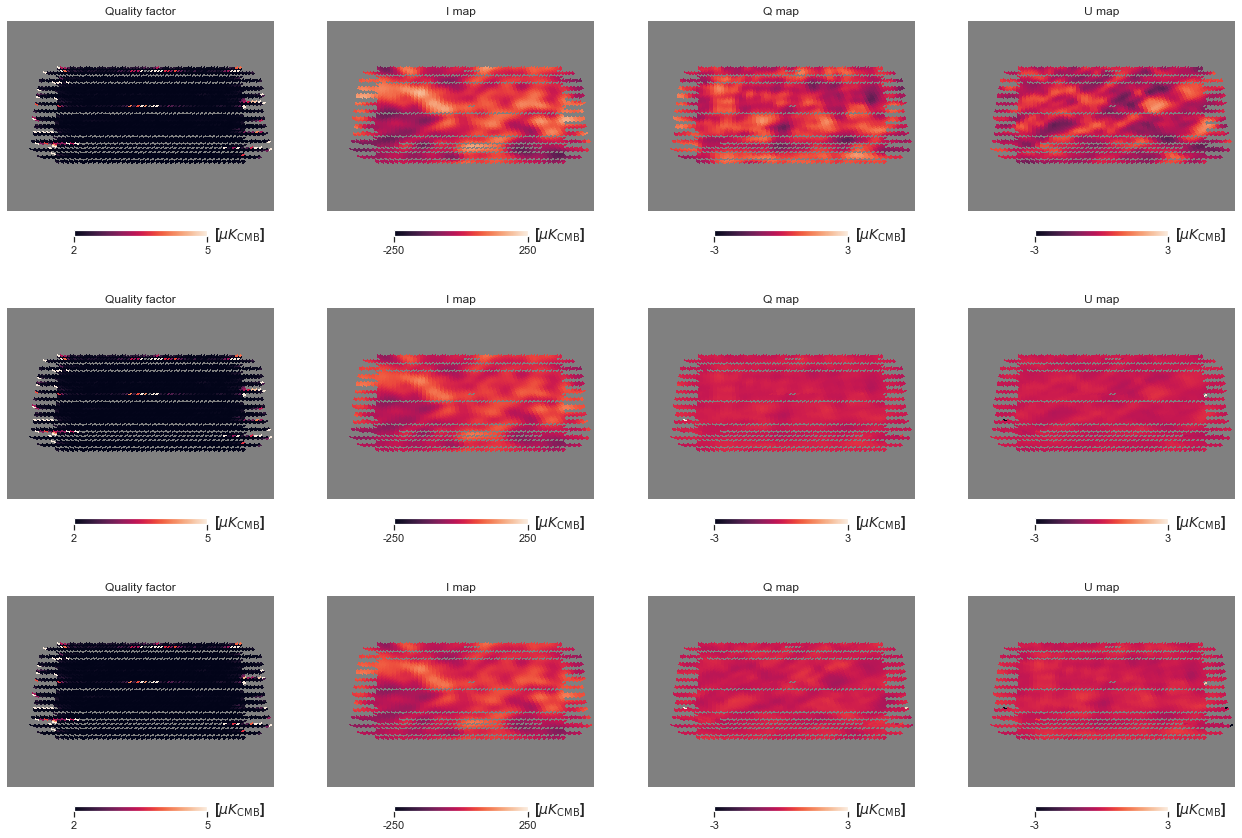

In [31]:
cond[cond == np.inf] = hp.UNSEEN
cart_opts = dict(unit=r'[$\mu K_{\mathrm{CMB}}$]', lonra=[-25, 10], latra=[-70, -45], hold=True)
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(22, 15))

ideal_cond[ideal_cond == np.inf] = hp.UNSEEN
plt.axes(axs[0,0])
hp.cartview(ideal_cond, min=2, max=5, title='Quality factor', **cart_opts)
plt.axes(axs[0,1])
hp.cartview(ideal_maps[0], min=-250, max=250, title='I map', **cart_opts)
plt.axes(axs[0,2])
hp.cartview(ideal_maps[1], min=-3, max=3, title='Q map', **cart_opts)
plt.axes(axs[0,3])
hp.cartview(ideal_maps[2], min=-3, max=3, title='U map', **cart_opts)

plt.axes(axs[1,0])
hp.cartview(cond, min=2, max=5, title='Quality factor', **cart_opts)
plt.axes(axs[1,1])
hp.cartview(maps[0], min=-250, max=250, title='I map', **cart_opts)
plt.axes(axs[1,2])
hp.cartview(maps[1], min=-3, max=3, title='Q map', **cart_opts)
plt.axes(axs[1,3])
hp.cartview(maps[2], min=-3, max=3, title='U map', **cart_opts)

plt.axes(axs[2,0])
hp.cartview(full_cond, min=2, max=5, title='Quality factor', **cart_opts)
plt.axes(axs[2,1])
hp.cartview(full_maps[0], min=-250, max=250, title='I map', **cart_opts)
plt.axes(axs[2,2])
hp.cartview(full_maps[1], min=-3, max=3, title='Q map', **cart_opts)
plt.axes(axs[2,3])
hp.cartview(full_maps[2], min=-3, max=3, title='U map', **cart_opts)



We can see leakeage between I and Q/U in the non-ideal map (usually) compared to the ideal HWP case. 

Finally, we can check the results by comparing them to the smoothed input map by plotting difference maps.

In [24]:
hp.smoothalm(alm, fwhm=np.radians(fwhm / 60.))

Sigma is 16.986436 arcmin (0.004941 rad) 
-> fwhm is 40.000000 arcmin


array([[ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        -2.97243437e+01+0.00000000e+00j, ...,
        -2.91074517e-05-4.62550199e-04j, -4.88242330e-04-1.98443776e-04j,
        -1.03466134e-04-4.40013511e-05j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        -3.13828142e-01+0.00000000e+00j, ...,
         3.43200961e-05-5.48283930e-05j,  1.05062790e-07-1.08354360e-05j,
        -1.72225765e-05-4.26043843e-05j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        -1.22458780e-02+0.00000000e+00j, ...,
         1.45495072e-06-9.21631524e-07j,  9.61633208e-07+1.15726965e-06j,
        -2.80740912e-06-1.91729986e-06j]])

In [25]:
sm_in = hp.alm2map(alm, hp.get_nside(maps[0]))
ideal_diff = ideal_maps - sm_in
diff = maps - sm_in

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


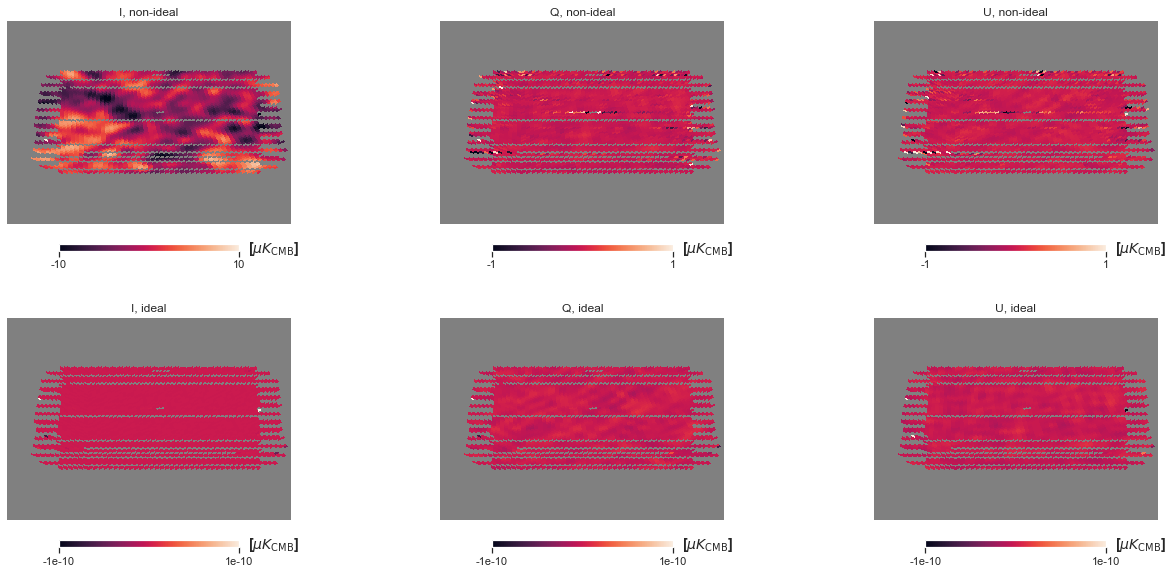

In [26]:
fig2, axs2 = plt.subplots(ncols=3, nrows=2, figsize=(22, 10))
plt.axes(axs2[0,0])
hp.cartview(diff[0], min=-10, max=10, title='I, non-ideal', **cart_opts)
plt.axes(axs2[0,1])
hp.cartview(diff[1], min=-1, max=1, title='Q, non-ideal', **cart_opts)
plt.axes(axs2[0,2])
hp.cartview(diff[2], min=-1, max=1, title='U, non-ideal', **cart_opts)
plt.axes(axs2[1,0])
hp.cartview(ideal_diff[0], min=-1e-10, max=1e-10, title='I, ideal', **cart_opts)
plt.axes(axs2[1,1])
hp.cartview(ideal_diff[1], min=-1e-10, max=1e-10, title='Q, ideal', **cart_opts)
plt.axes(axs2[1,2])
hp.cartview(ideal_diff[2], min=-1e-10, max=1e-10, title='U, ideal', **cart_opts)

So, up to some Q <-> U leakage at the 1e-10 uK level, we reproduce the expected result for the ideal HWP.
